# Online Learning and Stochastic/Mini-Batch Gradient Descent

## What if your data is so large that your models take hours to train?
- All of the models we've talked about so far use `batch` learning, which means the entire dataset is needed to update the parameters at each iteration.  
- Really large datasets make this unfeasible.  
- An alternative is `stochastic gradient descent (SGD)` or `mini-batch gradient descent`.  
- `SGD` is also referred to as iterative or `online learning` since it learns after 1 observation.  
- `mini-batch` learns after a batch of observations, something more than 1 and less than the number of observations in the dataset.

#### Difference from `Gradient Descent`
- Instead of updating the weights after each iteration, we update the weights based on the `cumulative sum of errors` over all the examples.  

$$
\vartriangle w = \eta \sum_{i}(y^{(i)}-\phi (z^{(i)}))x^{(i)}
$$

- $\eta$ is the learning rate.  
- `epochs` total number of times we are going to pass through the entire dataset (`outer for loop`), i.e., iterations.    
- `batches` number of observations we'll use to update the errors each time (`inner for loop`). For `SGD` this will be 1.    
- This is an approximation of gradient descent.  
- Generally will converge faster because we are updating the weights more often.  
- Since this is updated after after sample error, the error surface will be noisey.  
- While the surface is noisey, it can break out of local minima easier.  
- The trade-off to the ability to break out of local minimas is that it will can have trouble settling due to the variation that will now be in the loss curves.    
- The learning rate, $\eta$, is usually replaced by an adaptive learning rate, which usually helps reach the closer to the convergence point gradient descent would reach, i.e., the learning rate will generally decrease as epochs and iterations continue in order to better fine tune. This also helps with making sure it settles down. Usually this is implemented something like this:

$$
\frac{t_0}{epochs+t_1}
$$


- We'll want to reshuffle the data so the training examples are independently, identically distributed after each epoch (full training cycle) to prevent recurring cycles that could influence learning.  
- Another big benefit to `SGD` is that it allows us to stream observations into the model for training purposes, i.e., we'd never actually need to have all of the training data in memory for the purposes of modeling. If you data is say for example 10Gb and you only have 4Gb of memory on your machine, you wouldn't be able to load the entire dataset.

### Simple example of `SGD`
`Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, page 125.`

#### Create sample data that we'll eventually want to run a regression on.

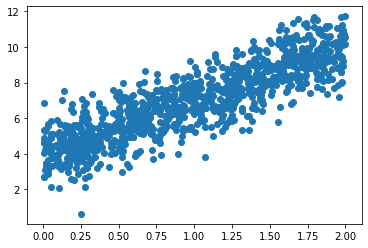

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

X = 2 * np.random.rand(1000,1)
y = 4 + 3 * X + np.random.randn(1000,1)

plt.scatter(X, y)
plt.show()

#### Adding the constant term to $X$
Remember you might need to do this depending on the software you are using!

In [2]:
X_b = np.c_[np.ones((1000,1)), X]
X_b[0, :]

array([1.        , 1.00574957])

### Simple implementation of stochastic gradient descent for regression
- Go through the dataset 25,000 times. 
- Update parameters after each observation.

In [3]:
import numpy as np

n_epochs = 25000
m = 1
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

# initialization to random numbers
# recall this will cause the results to differ each time unless we freeze the seed
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        
        # shuffling the dataset
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta -= eta * gradients
        
theta1, theta2 = theta
print(f'Intercept: {float(theta1):.2f}')
print(f'Slope: {float(theta2):.2f}')

Intercept: 3.07
Slope: 2.14


### Mini-batch
- Go through the dataset 500 times. 
- Update parameters after 50 observations.  

In [4]:
import numpy as np

n_epochs = 500
m = 100
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

# initialization to random numbers
# recall this will cause the results to differ each time unless we freeze the seed
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta -= eta * gradients
        
theta1, theta2 = theta
print(f'Intercept: {float(theta1):.2f}')
print(f'Slope: {float(theta2):.2f}')

Intercept: 3.98
Slope: 3.07


### Comparison to batch model
- All observations at once

In [5]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression(fit_intercept=False).fit(X_b,y)
s = lm.coef_[0][0]
m = lm.coef_[0][1]

print(f'Intercept: {s:.2f}')
print(f'Slope: {m:.2f}')

Intercept: 3.97
Slope: 3.01


> Not exact, but pretty close. The trade-off in performance relative to computation will be worthwhile for very large datasets. Mini-batch will be closer to batch results generally speaking.  

## Stochastic Gradient Descent (SGD) in scikit-learn
- [Linear Regression $\rightarrow$ LinearRegression:SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor)  
- [Various Classifiers $\rightarrow$ SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)  

#### SGDClassifier
The `loss` parameter controls the type of classifier you can use. The following is from the documentation:

>The possible options are `hinge`, `log`, `modified_huber`, `squared_hinge`, `perceptron`, or a regression loss: `squared_error`, `huber`, `epsilon_insensitive`, or `squared_epsilon_insensitive`.
<br><br>The `log` loss gives logistic regression, a probabilistic classifier. `modified_huber` is another smooth loss that brings tolerance to outliers as well as probability estimates. `squared_hinge` is like hinge but is quadratically penalized. `perceptron` is the linear loss used by the perceptron algorithm. The other losses are designed for regression but can be useful in classification as well; see SGDRegressor for a description.  

Use `.partial_fit` to utilize online/out-of-core learning:

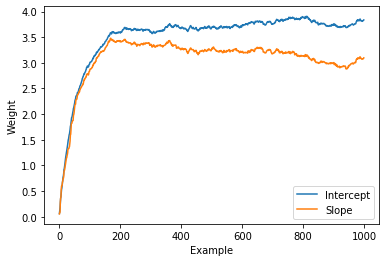

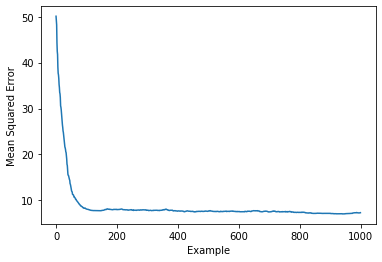

In [6]:
from sklearn.linear_model import SGDRegressor

sgd_lm = SGDRegressor(fit_intercept=False,
                      alpha=0, 
                      eta0=0.01, 
                      power_t=.05, 
                      learning_rate='adaptive'
                     )

samples = X_b.shape[0]
random_idx = np.random.choice(range(1000), size=1000, replace=False)

X_b = X_b[random_idx]
y = y[random_idx]

coefs = list()
mses = list()

for i in range(samples):
    sgd_lm = sgd_lm.partial_fit(X_b[i:i+1], y[i:i+1].ravel())

    b = sgd_lm.coef_[0]
    m = sgd_lm.coef_[1]
    coefs.append((b, m))
    
    yhat = sgd_lm.predict(X_b)
    mse = ((y - yhat)**2).mean()
    mses.append(mse)

plt.plot(range(samples), [x[0] for x in coefs])
plt.plot(range(samples), [x[1] for x in coefs])
plt.legend(['Intercept', 'Slope'])
plt.xlabel('Example')
plt.ylabel('Weight')
plt.show()

plt.plot(range(samples), mses)
plt.xlabel('Example')
plt.ylabel('Mean Squared Error')
plt.show()

> Parameter curve won't be as smooth as with batch updates.  
> See the noise in the loss curve that we haven't seen in batch gradient descent?

# Sentiment Analysis with Larger Data
- Sentiment analysis is a type of `natural language processing`.  
- We'll be trying to predict whether the text is positive or negative about the movie. The movie being reviewed is unknown.  
- We'll need to:
    - Clean the data.  
    - Extract features.  
    - Train a `batch` model.  
    - Compare to an `online` model.  
    - Look at extracting topic vectors.  
    
Data source is from [Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).](https://ai.stanford.edu/~amaas/data/sentiment/)

In [7]:
import pandas as pd

df = pd.read_csv('data/imdb.csv', encoding='utf-8')
df.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


## Bag-of-Words
We'll use a `bag-of-words` model for the prediction. Recall we've introduced this in earlier examples, such as the `spam` detection examples.

`Bag-of-words` will let us represent the text reviews as simple numerical vectors.  

- Create a `vocabulary` of unique tokens (i.e., words).  
- Construct feature vector, with the counts of how often the word appears. These will mostly be sparse vectors, since each review will only use a small percentage of the unique words across the entire dataset.

In [9]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()

docs = np.array(['hello there bill the ', 
                  'the ravens defense is terrible',
                  'the traffic on 695 is silly',
                  'the sun was shining today',
                  'my daughter keeps me up to all hours of the night'
                 ])

bag = count.fit_transform(docs)
print(count.vocabulary_)

{'hello': 5, 'there': 20, 'bill': 2, 'the': 19, 'ravens': 14, 'defense': 4, 'is': 7, 'terrible': 18, 'traffic': 23, 'on': 13, '695': 0, 'silly': 16, 'sun': 17, 'was': 25, 'shining': 15, 'today': 22, 'my': 10, 'daughter': 3, 'keeps': 8, 'me': 9, 'up': 24, 'to': 21, 'all': 1, 'hours': 6, 'of': 12, 'night': 11}


> The above shows the indixes of where the words appear in the matrix

In [10]:
bag

<5x26 sparse matrix of type '<class 'numpy.int64'>'
	with 31 stored elements in Compressed Sparse Row format>

> Stores a sparse matrix since most of the documents only contain a small percentage of the overall vocabulary.

However, you can covert to a normal array, if needed:

In [11]:
print(bag.toarray())

[[0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1]
 [0 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0]]


#### Raw Term Frequencies
Values are also called raw term frequencies, $tf(t,d)$ - number of times a term, $t$, appears in a document, $d$.

#### Note
- Order of the words `is not` accounted for. The same vector can be created from `hello there bill` and `there bill hello`.

#### Document sparseness

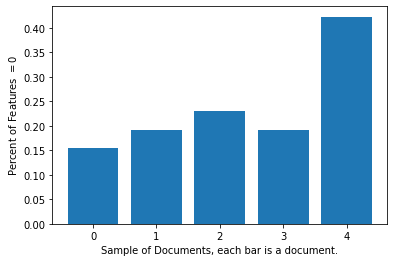

In [13]:
plt.bar(range(5), bag.toarray().mean(axis=1))
plt.ylabel('Percent of Features $=0$')
plt.xlabel('Sample of Documents, each bar is a document.')
plt.show()

#### $N-$grams
A way to add weight to the sequencing of tokens, though it explodes the size of the feature matrix if you use multiple $N-$grams.

`the sun is shining`: 1-gram $\rightarrow$ 'the', 'sun', 'is', 'shining'  
`the sun is shining`: 2-gram $\rightarrow$ 'the sun', 'sun is', 'is shining'

### Issues with text data
- Not all tokens are words, e.g., punctuation, random numbers, ...  
- Misspelled words - really need a spell-checking API, or hopefully these are rare. 
- Synonyms, generic and business-specific.  
    - Create a mapping dictionary, e.g., {'title 2':['disability', 'title ii', 'disabled worker'}
   
- Not all words are meaningful, e.g., 'the', sometimes referred to as `stop words`. These can be removed using common lists.   
- Words may not be common across a language, but are across the documents, e.g., some type of business specific word or maybe the name of a product in product reviews. We can use `term frequency-inverse document frequency`. This reduces the weights of words that occur frequency across documents.  

$$
tf-idf(t,d)=tf(t,d) \times idf(t,d), \space where \space idf(t,d)=log\frac{1 + n_d}{1+df(d,t)}
$$

In the above $n_d$ is the total number of documents, $df(d,t)$ is the documents that contain $t$.

In [14]:
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(smooth_idf=False)

tfidf = tfidf.fit_transform(bag)

print(tfidf.toarray().round(2))

[[0.   0.   0.56 0.   0.   0.56 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.22 0.56 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.52 0.   0.   0.38 0.   0.   0.   0.   0.   0.
  0.52 0.   0.   0.   0.52 0.2  0.   0.   0.   0.   0.   0.  ]
 [0.46 0.   0.   0.   0.   0.   0.   0.34 0.   0.   0.   0.   0.   0.46
  0.   0.   0.46 0.   0.   0.18 0.   0.   0.   0.46 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.49 0.   0.49 0.   0.19 0.   0.   0.49 0.   0.   0.49]
 [0.   0.31 0.   0.31 0.   0.   0.31 0.   0.31 0.31 0.31 0.31 0.31 0.
  0.   0.   0.   0.   0.   0.12 0.   0.31 0.   0.   0.31 0.  ]]


#### Cleaning Text Data

In [15]:
print('Last 50 characters of first review:\n')
df.loc[0, 'review'][-50:]

Last 50 characters of first review:



'is seven.<br /><br />Title (Brazil): Not Available'

> Contains HTML tags and punctuation. Some punctuation might be meaningful, e.g., emojis.

We can create a cleaning function, that could be applied to training and test data. We aren't using any data specific to the test set, so this doesn't cause leakage. We'll do this with regular expressions, which can best be described as:

<img src='files/diagrams/cat.jpeg' style='width: 500px'>

#### Regular Expressions
- Very powerful, but takes time to build complex ones.  
- See [Python's re package for lite version of documentation](https://docs.python.org/3/library/re.html).  
- For our purpose, we just want to remove the tags and standardize the text, however, regular expressions can be used to find positions in the text and extract complex features.

In [16]:
import re

def preprocessor(text):
    # find tags and replace with empty string
    text = re.sub('<[^>]*>', '', text)
    
    # find emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    
    # return the cleaned text
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-',''))
    return text

examples = ['Hello <Br> I liked your hat :)', 
            'What a relief! That is great news',
            'Bill, thanks - I appreciate it'
           ]

for ex in examples:
    print(preprocessor(ex))

hello i liked your hat :)
what a relief that is great news
bill thanks i appreciate it


### What about `hat` versus `hats`?
In many cases the plural forms of words don't provide additional semantic meaning. It is accepted practice to form these variations to reduce the dimensionality of the data. There are several methods, including [`stemming`](https://en.wikipedia.org/wiki/Stemming) and [`lemmatization`](https://en.wikipedia.org/wiki/Lemmatisation). We'll use `stemming` since it's simplier and less computationally expensive.

In [17]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

tokenizer_porter('the hats were great. this hat was amazing.')

['the', 'hat', 'were', 'great.', 'thi', 'hat', 'wa', 'amazing.']

### Custom Dictionaries
In business contexts, there might be multiple ways to convey the same concept, e.g., in disability programs, `disability` might be written as `t2 dib`, `title ii disabled worker`, or `oasdi`.

In [18]:
businessTerms = {'t2 dib':'disability',
                 'title ii disabled worker':'disability', 
                 'oasdi':'disability'
                }

ex = ['I have to file for t2 dib.',
      'I have to file for title ii disabled worker.',
      'I have to file for oasdi.'
     ]

print(*ex, sep='\n')

I have to file for t2 dib.
I have to file for title ii disabled worker.
I have to file for oasdi.


In [19]:
import re

for e in ex:
    for k in businessTerms.keys():
        r = re.search(k, e)
        if r:
            print(e)
            print(r)
            print(re.sub(k, businessTerms[k], e))
            print('\n')

I have to file for t2 dib.
<re.Match object; span=(19, 25), match='t2 dib'>
I have to file for disability.


I have to file for title ii disabled worker.
<re.Match object; span=(19, 43), match='title ii disabled worker'>
I have to file for disability.


I have to file for oasdi.
<re.Match object; span=(19, 24), match='oasdi'>
I have to file for disability.




> Not aware these types of replacements that would be useful for the IMDB data, but this could be useful in an actual business application.

# Stop Words
Stop words are generally semantically meaningless and can usually be removed for analyses that are using frequency counts.

If you haven't used `nltk` before, you might need to run:

```python
import nltk

nltk.download('stopwords')
```

In [20]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

print('Sample stop words:\n')
print(*stop[:5], sep='\n')

Sample stop words:

i
me
my
myself
we


In [21]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer_porter(text, stopwords):
    return [porter.stem(word) for word in text.split() if word not in stopwords]

tokenizer_porter('the hats were great. this hat was amazing.', stop)

['hat', 'great.', 'hat', 'amazing.']

> See [translate from string to remove punctuation](https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string).

# `Batch` Classifier for `imdb`
Create a training and test set. The data was already shuffled.

In [22]:
X_train = df.loc[:24999, 'review'].values
y_train = df.loc[:24999, 'sentiment'].values

X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

print(f'Training samples: {X_train.shape[0]:,}')
print(f'Test samples: {X_test.shape[0]:,}')

Training samples: 25,000
Test samples: 25,000


Ideally, we'd want to use `grid search`, but that could take an hour to run depending on the amount of parameters we are searching over. We'll take a couple liberties and see how long it takes to train one model.

In [23]:
import datetime
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

st = datetime.datetime.now()

tfidf = TfidfVectorizer(strip_accents='ascii', 
                        lowercase=True,
                        stop_words='english',
                        analyzer='word'
                       )

p = Pipeline([('vect', tfidf),
              ('lm', LogisticRegression(C=10, solver='liblinear'))
             ])

p = p.fit(X_train, y_train)

en = datetime.datetime.now()

el = en - st
print(f'Time to fit model: {el}')

Time to fit model: 0:00:04.430761


In [24]:
p_score =  p.score(X_test, y_test)
print(f'Test accuracy: {p_score:.2%}')

Test accuracy: 89.04%


> Took about 4-5 seconds to run, but what if it were 25 million records instead of 25,000? Depending on your computer, 25 million records may not even fit into your RAM...

#### Online learning to the rescue!
- We can stream the documents into the model with `SGD` or `mini-batch`.  
- We will need to add some processing utilities to clean some of the streaming data. But since we are working with one or a couple dozen records at a time, that isn't a lot of processing overhead.

The tokenizer should look familiar:

In [25]:
import numpy as np
import re
from nltk.corpus import stopwords

stop = stopwords.words('english')

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-',''))
    tokens = [w for w in text.split() if w not in stop]
    return tokens

tokenizer_test = 'hi! there bill, it is great!!!! to see you :)'
print(tokenizer(tokenizer_test))

['hi', 'bill', 'great', 'see', ':)']


Then we'll need a function to stream the documents (reviews).

In [26]:
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv)
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label
            
next(stream_docs('data/imdb.csv'))

('"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />""Murder in Greenwich"" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich f

We'll need another function to get `mini batches` of data.

In [27]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

get_minibatch(stream_docs('data/imdb.csv'), 2)

(['"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />""Murder in Greenwich"" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich 

`CountVectorizer` requires holding the data in-memory, but `HashingVectorizer` can be used.

From [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html#sklearn.feature_extraction.text.HashingVectorizer):

This text vectorizer implementation uses the hashing trick to find the token string name to feature integer index mapping.

This strategy has several advantages:

- it is very low memory scalable to large datasets as there is no need to store a vocabulary dictionary in memory.  
- it is fast to pickle and un-pickle as it holds no state besides the constructor parameters.  
- it can be used in a streaming (partial fit) or parallel pipeline as there is no state computed during fit.  

There are also a couple of cons (vs using a CountVectorizer with an in-memory vocabulary):

- there is no way to compute the inverse transform (from feature indices to string feature names) which can be a problem when trying to introspect which features are most important to a model.  
- there can be collisions: distinct tokens can be mapped to the same feature index. However in practice this is rarely an issue if n_features is large enough (e.g. 2 ** 18 for text classification problems).  
- no IDF weighting as this would render the transformer stateful.

`tl:dr`: it lets you use term frequencies without holding the entire data in-memory, but you cannot use `tf-idf` or look at the vocabulary.

In [28]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

# tokenizer is the function we created a few cells above
vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**21,
                         preprocessor=None,
                         tokenizer=tokenizer
                        )

clf = SGDClassifier(loss='log', random_state=1)
doc_stream = stream_docs(path='data/imdb.csv')

print('Ready to model!')

Ready to model!


In [29]:
import pyprind

pbar = pyprind.ProgBar(50)

classes = np.array([0, 1])
for _ in range(50):
    X_train, y_train = get_minibatch(doc_stream, size=500)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:13


In [30]:
X_test, y_test = get_minibatch(doc_stream, size=25000)
X_test = vect.transform(X_test)

t_scr = clf.score(X_test, y_test)
print(f'Test accuracy: {t_scr:.2%}')

Test accuracy: 86.93%


> Very similar performance using `online modeling`. If the training data was actually really huge, `online` learning may have had to be our default. For our `online` model, only `500` documents were loaded into memory at any one time.

# Brief interlude for topic modeling
50,000 reviews is way too many documents for individuals to read in order to get an impression of what people are saying. We can use `Latent Dirichlet Allocation` to reduce the text into topic vectors so we understand what is being stated (generally) in the documents with relatively little overhead.

In a nutshell, it finds words that frequently appear together across documents. It uses two matrices (1) `document-to-topic` and (2) `word-to-topic` that when multiplied together reproduce the bag-of-words matrix.  Like PCA, you `need to define the number of topics`.

Starting with the word frequencies of the `imdb` data:

In [31]:
import datetime

from sklearn.feature_extraction.text import CountVectorizer

st = datetime.datetime.now()

# exclude words that occur in more than 10% of the documents
# include most common 5000 words
count = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)

X = count.fit_transform(df['review'].values)

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, 
                               random_state=10, 
                               learning_method='batch'
                              )

X_topics = lda.fit_transform(X)

en = datetime.datetime.now()

el = en-st

print(f'Time to complete: {el}')

Time to complete: 0:04:49.951232


Word importances for each of the 5,000 words for each topic:

In [32]:
lda.components_.shape

(10, 5000)

In [33]:
top_words = 5

feature_names = count.get_feature_names()

for topic_idx, topic in enumerate(lda.components_):
    print(f'Topic {topic_idx+1}')
    print(' '.join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))

Topic 1
comedy music fun song jokes
Topic 2
role performance father wife comedy
Topic 3
series episode tv episodes john
Topic 4
horror killer house gore dead
Topic 5
book novel read woman performance
Topic 6
dvd effects horror special game
Topic 7
action feel music script audience
Topic 8
war human american men documentary
Topic 9
worst minutes guy money stupid
Topic 10
girl school sex girls family


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


> You would need to convert these into logical categories to present to your boss. You would want to check the topics match the text, since LDA can extract topics that aren't much stronger than random noise.

In [34]:
comedy = X_topics[:, 0].argsort()[::-1]
for iter_idx, movie_idx in enumerate(comedy[:3]):
    print(f'\nComedy {iter_idx+1}:')
    print(df['review'][movie_idx][:300], '...')


Comedy 1:
AristoCats is such a terrific Disney classic that I just loved so much as a kid. Still to this day I can't resist watching it, it's just such a wonderful and charming film with great animation and lovely songs. I really miss the animation films like AristoCats, they had perfect voices not to mention ...

Comedy 2:
I think Lion King 1 1/2 is one of the best sequels ever as if not the best out of the three Lion King movies! In the movie Timon and Pumbaa tell us where they came from and having trouble fitting in with others such as Timon having trouble digging tunnels with other Meercats! Timon and Pumbaa journe ...

Comedy 3:
I previously thought that this film was the lamest of the Muppet films. I would like now to retract that statement. In my opinion now, the lamest MUppet film was the TV movie IT'S A VERY MERRY MUPPET Christmas, am IT'S A WONDERFUL LIFE rip off that was truly dreadful. MUPPETS TAKE MANHATTAN is nothi ...


> Seem reasonable?

# Readings and Resources
- [scikit-learn out of core learning](https://scikit-learn.org/0.15/modules/scaling_strategies.html)
- [Google's tutorial on regular expressions](https://developers.google.com/edu/python/regular-expressions)  
- [Python's regular expression documentation](https://docs.python.org/3/library/re.html)  
- [Standord NLP](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)  
- [NLTK Book - Natural Language Processing with Python](https://www.nltk.org/book/)  
- [Latent Dirichlet Allocation paper by Blei and el.](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)  
- [IncrementialPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html)  
- [Text Mining with R Online Textbook](https://www.tidytextmining.com)